Submitted By:Saeed Rahman

# Analysing the trades of 2016 Thinkorswim Trading Challenge

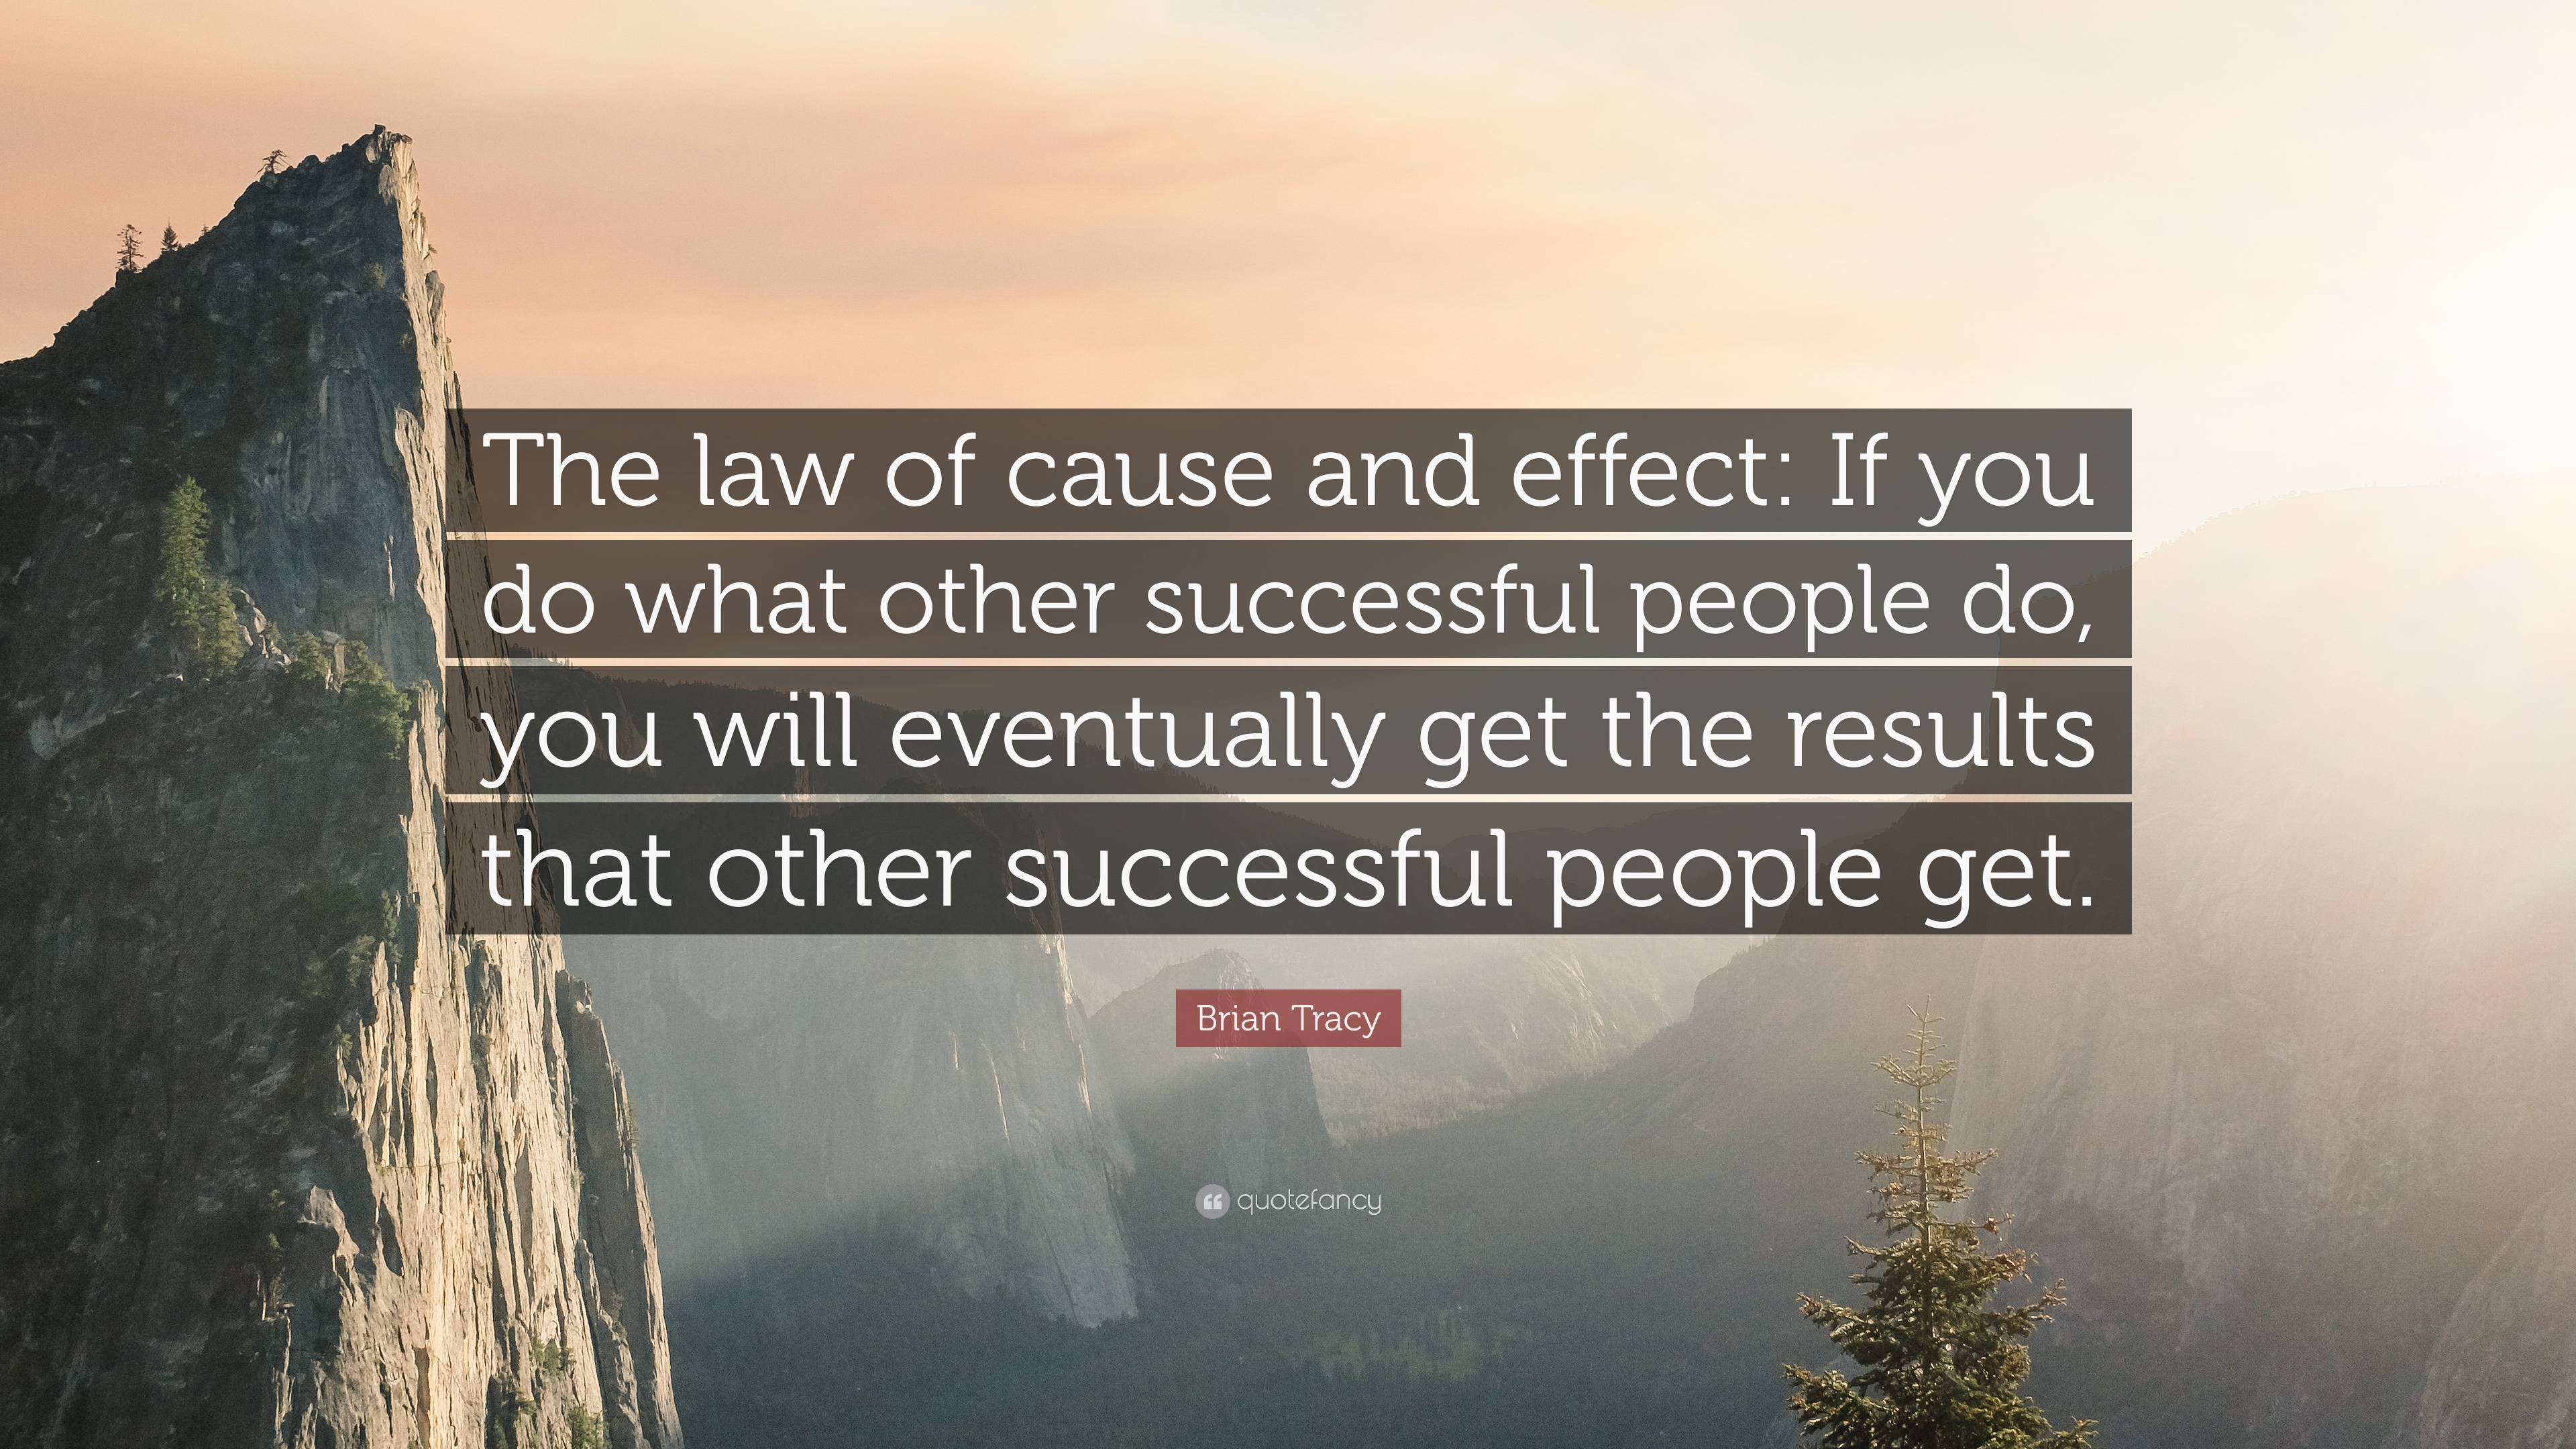

In [44]:
from IPython.core.display import Image
Image(filename=("intro.JPG"))

I recently participated in a trading competition and eventhough I made profit at the end of the competition, I wasn't able to come anywhere near the performance of other competitors. On analyzing the reason for failure by comparing my strategy with a fellow competitor I met over the internet, I came to realize that the main reasons for failure was
1) The category of securities I chose
2) The time frame I traded 
3) The frequency of trades
4) Traded conservatively
and much more.....

Then I tumbled upon the Thinkorswim trading challenge webpage where the trades of the 2016 winners was posted.
And I thought why not analyze it to get the general idea of the strategy the winner has adopted to win the 2016 challenge. 
Maybe then me or someone else can frame a strategy based on this analyzis.

The Thinkorswim trading challenge is a coveted competition among traders all over world. Every year thousands of experienced
traders and students compete in groups using paper money make the highest profit in one month. The organizers publish the trades
of the past winners in their webpage and I thought of analyzing it to see their pattern and preference of strategies. For this
particular notebook I have choosed the 2016 Winner.

The first step was to obtain the data using beautifulsoup python package to obtain the table data from http://tinyurl.com/mrow6xx
Then save it as a .csv file


In [45]:
import pandas as pd
import numpy as np
import re
import datetime
import locale
from time import strptime
import ystockquote
from bokeh.charts import Bar, output_file, BoxPlot, Donut, show
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show 
from pylab import *
import string
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly 
import calmap
import warnings

In [46]:
with open('All for tony, thinkorswim trade challenge winner2.txt') as f:
    table = pd.read_table(f, sep='\s+', engine='python', header=None,   lineterminator='\n')

table.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11/04/2016,02:21:43,PM,BOT,"+5,500",NEM,100,4,NOV,16,37.5,CALL,@.15,"$82,500.00"
1,11/04/2016,01:57:41,PM,SOLD,-300,UVXY,100,11,NOV,16,18.5,PUT,@2.25,"-$67,500.00"
2,11/04/2016,01:35:00,PM,BOT,+666,VXX,100,11,NOV,16,36.0,CALL,@3.40,"$226,440.00"
3,11/04/2016,01:27:59,PM,BOT,+200,TSLA,100,11,NOV,16,190.0,PUT,@4.60,"$92,000.00"
4,11/04/2016,01:07:58,PM,BOT,"+1,200",GPRO,100,11,NOV,16,11.5,PUT,@.70,"$84,000.00"


# # Preprocessing and cleaning data

We can see that the transaction data is not formatted for analyzis.
Therefore, we have to do some preprocessing.
1) The transactions needs to be grouped and converted into round trip trades.
2) Cashflow needs to be converted into profit and loss based on the round trip trades.
3) Getting rid of the @,$ symbols in the security prices and other column
4) Formating the datatypes and getting the time stamp and other variables in correct format
5) Formating the secuuirty name and the quantity.

In [47]:
table.iloc[:,0]=table.iloc[:,0]+" "+table.iloc[:,1]+""+table.iloc[:,2]
table.iloc[:,5]=table.iloc[:,5]+" "+table.iloc[:,6].map(str)+" "+table.iloc[:,7].map(str)+" "+table.iloc[:,8].map(str)+" "+table.iloc[:,9].map(str)+" "+ \
table.iloc[:,10].map(str)+" "+table.iloc[:,11].map(str)
table.iloc[:,11]=table.iloc[:,8].map(str)+"/"+table.iloc[:,7].map(str)+"/20"+table.iloc[:,9].map(str)
table=table.drop(table.columns[[1,2,6,7,8,9,10]],axis=1)

In [48]:
table.columns=['Time','Position','Quantity','Security','Expiry_Date','Price','Cash_flow']
table.Expiry_Date = pd.to_datetime(table.Expiry_Date,format="%b/%d/%Y")
table.Price =table.Price.str.replace('@','')
table.Price =table.Price.astype(float)
table.Cash_flow =table.Cash_flow.str.replace('$','')
table.Cash_flow =table.Cash_flow.str.replace(',','')
table.Cash_flow =table.Cash_flow.astype(float)
table.Quantity =table.Quantity.str.replace(',','')
table.Quantity = table.Quantity.astype(float)
table.head()

,Time,Position,Quantity,Security,Expiry_Date,Price,Cash_flow
0,11/04/2016 02:21:43PM,BOT,5500.0,NEM 100 4 NOV 16 37.5 CALL,2016-11-04,0.15,82500.0
1,11/04/2016 01:57:41PM,SOLD,-300.0,UVXY 100 11 NOV 16 18.5 PUT,2016-11-11,2.25,-67500.0
2,11/04/2016 01:35:00PM,BOT,666.0,VXX 100 11 NOV 16 36.0 CALL,2016-11-11,3.40,226440.0
3,11/04/2016 01:27:59PM,BOT,200.0,TSLA 100 11 NOV 16 190.0 PUT,2016-11-11,4.60,92000.0
4,11/04/2016 01:07:58PM,BOT,1200.0,GPRO 100 11 NOV 16 11.5 PUT,2016-11-11,0.70,84000.0


In [49]:
locale.setlocale(locale.LC_ALL, "") # for datetime.strptime
table.Time = pd.to_datetime(table.Time,format="%x %I:%M:%S%p")

In [50]:
security = table.Security.unique()
average_holding_period =[0]* len(security)
total_profit =[0]* len(security)
average_profit =[0]* len(security)
number_of_trades=[0]* len(security)

trade_analyzis = {'security': security,'average_holding_period':[0]* len(security),\
                  'total_profit':[0]* len(security),'average_profit':[0]* len(security),'number_of_trades':[0]* len(security),\
                  'outstanding_quantity':[0]* len(security),'start_time':[0]* len(security),\
                  'direction':[0]* len(security),'expiry_date':[0]* len(security),'days_till_expiry':[0]* len(security)}
trade_analyzis = pd.DataFrame(trade_analyzis)
table.sort_values(by='Time',inplace=True)

#### Converting to round trip trades

In [51]:
warnings.filterwarnings('ignore')
for indx,row in table.iterrows():
    if trade_analyzis[trade_analyzis.security==row.Security].outstanding_quantity.item() == 0:
        trade_analyzis.loc[trade_analyzis.security==row.Security,'number_of_trades']+= 1
        if row.Position=='BOT':
            trade_analyzis.loc[trade_analyzis.security==row.Security,'direction']='Long'
        else:
            trade_analyzis.loc[trade_analyzis.security==row.Security,'direction']='Short'

    trade_analyzis.loc[trade_analyzis.security==row.Security,'total_profit'] = row.Cash_flow
    trade_analyzis.loc[trade_analyzis.security==row.Security,'outstanding_quantity'] += int(row.Quantity)
    trade_analyzis.loc[trade_analyzis.security==row.Security,'expiry_date'] = row.Expiry_Date
    
    if (trade_analyzis[trade_analyzis.security==row.Security].outstanding_quantity.item() != 0):
        trade_analyzis.loc[trade_analyzis.security==row.Security,'start_time'] = row.Time
    else:
        trade_analyzis.loc[trade_analyzis.security==row.Security,'average_holding_period']+=\
        ((row.Time- trade_analyzis.loc[trade_analyzis.security==row.Security,'start_time'])/datetime.timedelta(hours=1))
        trade_analyzis[trade_analyzis.security==row.Security].average_holding_period = 0


trade_analyzis.loc[:,'total_profit']=trade_analyzis.total_profit*-1
trade_analyzis.loc[:,'average_profit'] = round(trade_analyzis.total_profit/trade_analyzis.number_of_trades ,2) 
trade_analyzis.loc[:,'days_till_expiry'] = abs((trade_analyzis.expiry_date - trade_analyzis.start_time))
output_notebook()
trade_analyzis.head()


Loading BokehJS ...

,average_holding_period,average_profit,days_till_expiry,direction,expiry_date,number_of_trades,outstanding_quantity,security,start_time,total_profit
0,0.000000,-82500.0,0 days 14:21:43,Long,2016-11-04 00:00:00,1,5500,NEM 100 4 NOV 16 37.5 CALL,2016-11-04 14:21:43,-82500.0
1,1.099167,67500.0,6 days 11:08:16,Long,2016-11-11 00:00:00,1,0,UVXY 100 11 NOV 16 18.5 PUT,2016-11-04 12:51:44,67500.0
2,0.000000,-226440.0,6 days 10:25:00,Long,2016-11-11 00:00:00,1,276,VXX 100 11 NOV 16 36.0 CALL,2016-11-04 13:35:00,-226440.0
3,0.123056,-46000.0,6 days 10:32:01,Long,2016-11-11 00:00:00,2,200,TSLA 100 11 NOV 16 190.0 PUT,2016-11-04 13:27:59,-92000.0
4,0.000000,-84000.0,6 days 10:52:02,Long,2016-11-11 00:00:00,1,1200,GPRO 100 11 NOV 16 11.5 PUT,2016-11-04 13:07:58,-84000.0


In [52]:
# Finding the underlying
warnings.filterwarnings('ignore')
trade_analyzis['underlying']=trade_analyzis.security.str.extract('([A-Z]\w{0,})', expand=True)

# removing columns with outstanding quantity
trade=trade_analyzis[trade_analyzis.outstanding_quantity==0]
trade.sort_values(by='start_time',inplace=True)

#### Let's start Visualizing 

In [53]:
melted=pd.DataFrame(trade.groupby('underlying').sum()).reset_index()
melted.loc[:,'average_profit']=round(melted.total_profit/melted.number_of_trades,2)
temp_tot_profit = melted.total_profit.sum()
melted['percentage_profit'] = melted.total_profit/temp_tot_profit
melted

,underlying,average_holding_period,average_profit,number_of_trades,outstanding_quantity,total_profit,percentage_profit
0,AAPL,22.613333,212800.00,1,0,212800.0,0.074901
1,AET,3.255556,9600.00,1,0,9600.0,0.003379
2,APC,21.965556,33300.00,1,0,33300.0,0.011721
3,CHK,48.777778,34833.33,3,0,104500.0,0.036782
4,GDX,262.440000,34400.00,8,0,275200.0,0.096864
5,GLD,72.786667,29600.00,1,0,29600.0,0.010419
6,HP,21.609167,46550.00,1,0,46550.0,0.016385
7,KO,216.087222,1890.00,1,0,1890.0,0.000665
8,MYL,2.524167,17400.00,1,0,17400.0,0.006124
9,NEM,187.568333,57380.00,5,0,286900.0,0.100982


#### Profit per Security 

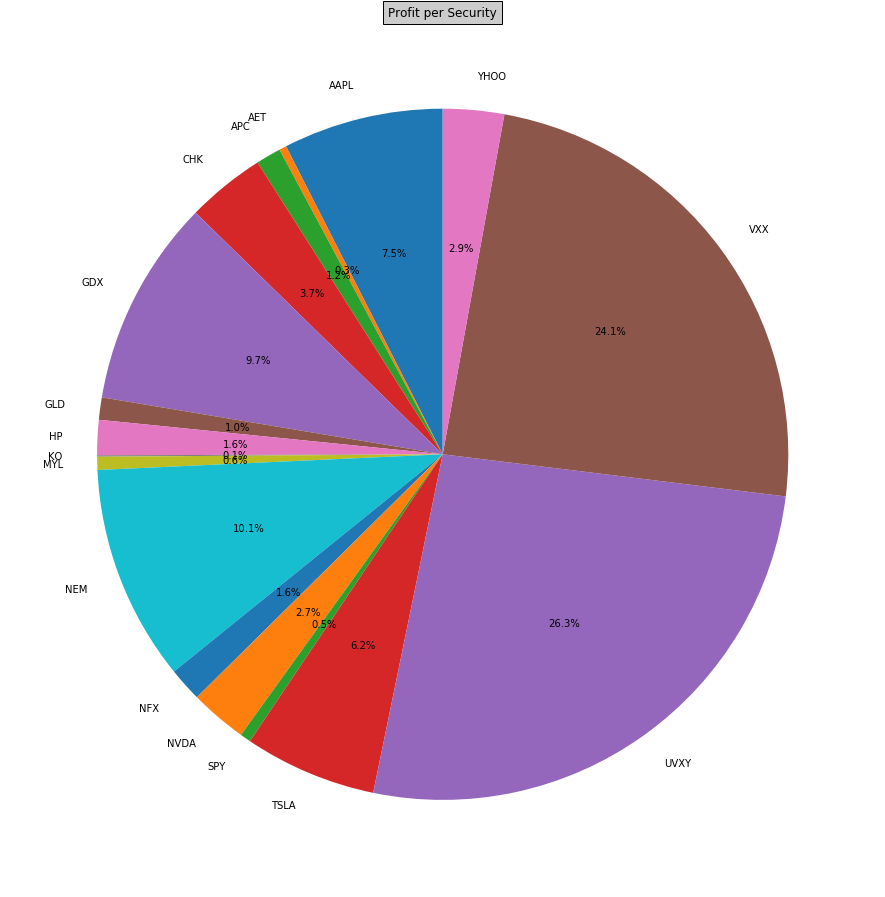

In [54]:
from pylab import *
figure(1, figsize=(15,15))
ax = axes([0.8, 0.8, 0.8, 0.8])
pie(melted.percentage_profit, labels=melted.underlying,
                autopct='%1.1f%%', startangle=90)
title('Profit per Security', bbox={'facecolor':'0.8', 'pad':5})
show()

#### Profit Distribution - Box Plot

In [62]:
from bokeh.charts import Bar, output_file, BoxPlot
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show 
output_notebook
p = BoxPlot(trade, values='total_profit', label='underlying',
            title="Profit Distribution for each Security",legend=False)
show(p, notebook_handle=True)

#### Average holding period for each secuirty

In [63]:
# from bokeh.charts import Bar, output_file, BoxPlot
# from bokeh.plotting import figure
# from bokeh.io import output_notebook, push_notebook, show 
output_notebook
p = Bar(melted, 'underlying', values='average_holding_period', title="Average Holding Period for each security",legend=False,\
       ylabel='Average Holding Period in minutes', xlabel= 'Underlying Securities')
show(p, notebook_handle=True)

#### Profit/Loss Based on direction of trade

In [57]:
temp=pd.DataFrame(trade.groupby('direction').sum()).reset_index()
temp
output_notebook()
p = Bar(temp, 'direction', values='total_profit', title="Profit in Diretion", color='total_profit',legend=False,\
       xlabel='Direction',ylabel='Profit')

show(p,notebook_handle=True)

Loading BokehJS ...

#### Profit vs Average Holding Period - Bubble Plot

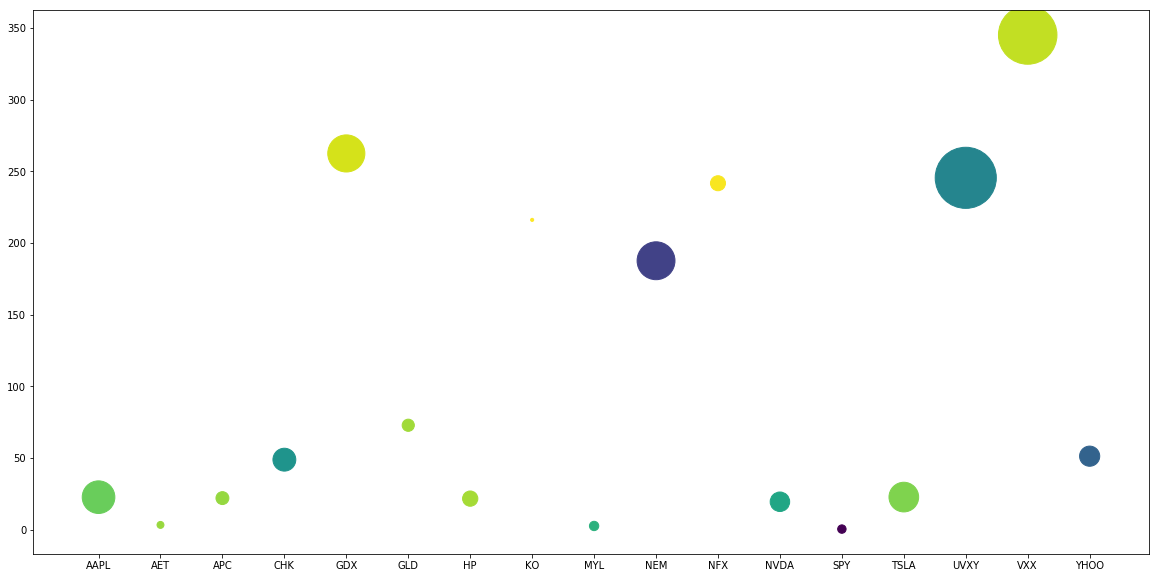

In [58]:
%matplotlib inline
x=melted.index.values
y=melted.average_holding_period.values
s=melted.total_profit.values/200
my_xticks =list(melted.underlying)
colors = np.random.rand(len(x))
plt.figure(figsize=(20,10))
plt.xticks(x, my_xticks)
plt.scatter(x, y,s=s, c=colors)
# Chart title
plt.title='Bubble Plot of Profit vs Holding Period for Each securities traded'
plt.xlabel='my data'
plt.ylabel='Average Holding Period'
plt.show()

#### Calendar Heat Map

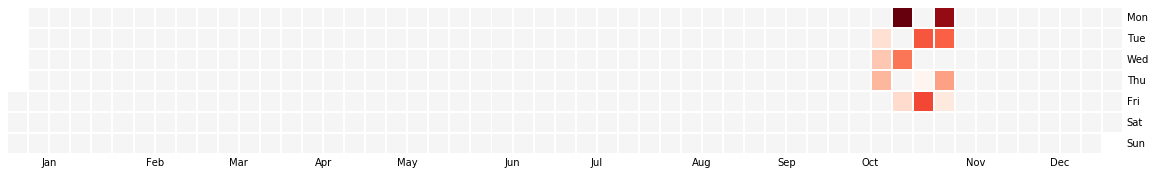

In [59]:
warnings.filterwarnings('ignore')
cal=pd.Series(trade.total_profit.values,index=trade.start_time)
cal
plt.figure(figsize=(20,10))
calmap.yearplot(cal, year=2016)

In [60]:
melted2=pd.DataFrame(trade.groupby('days_till_expiry').sum()).reset_index()
melted2.loc[:,'average_profit']=round(melted.total_profit/melted.number_of_trades,2)
temp_tot_profit = melted2.total_profit.sum()
melted2['percentage_profit'] = melted2.total_profit/temp_tot_profit
melted2.head()

,days_till_expiry,average_holding_period,average_profit,number_of_trades,outstanding_quantity,total_profit,percentage_profit
0,09:11:41,24.043056,212800.00,1,0,-10500.0,-0.003696
1,10:05:08,20.891944,9600.00,1,0,36000.0,0.012671
2,10:28:24,21.185278,33300.00,1,0,-11000.0,-0.003872
3,12:22:04,1.525556,34833.33,1,0,69300.0,0.024392
4,12:23:17,1.537222,34400.00,1,0,72000.0,0.025342


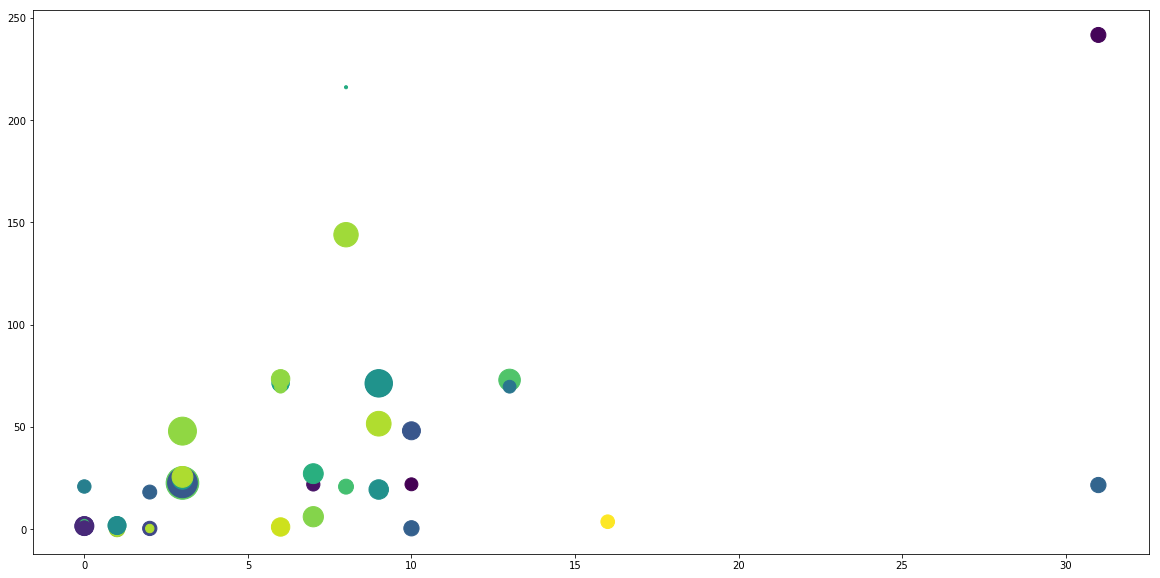

In [61]:
warnings.filterwarnings('ignore')
%matplotlib inline
x=(melted2.days_till_expiry / np.timedelta64(1, 'D')).astype(int)
x
# melted2.days_till_expiry.dt.days
# x=melted2.days_till_expiry.astype(int)
y=melted2.average_holding_period.values
s=melted2.total_profit.values/200
# # my_xticks =list(melted.underlying)
colors = np.random.rand(len(x))
plt.figure(figsize=(20,10))
# plt.xticks(x, my_xticks)
plt.scatter(x, y,s=s, c=colors)
# Chart title
plt.title='Bubble Plot of Profit vs Days till expiry vs Average holding period for Each securities traded'
plt.xlabel='my data'
plt.ylabel='Average Holding Period'
plt.show()